In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls "/gdrive/My Drive/Frame_prediction_kitti/Train_new/"

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
0000000000.png	0000000091.png	0000000182.png	0000000273.png	0000000364.png
0000000001.png	0000000092.png	0000000183.png	0000000274.png	0000000365.png
0000000002.png	0000000093.png	0000000184.png	0000000275.png	0000000366.png
0000000003.png	0000000094.png	0000000185.png	0000000276.png	0000000367.png
0000000004.png	0000000095.png	0000000186.png	0000000277.png	0000000368.png
0000000005.png	0000000096.png	0000000187.png	0000000278.png	0000000369.png
0000000006.png	0000000097.png	0000000188.png	0000000279.png	0000000370.png
0000000007.png	0000000098.png	0000000189.png	0000000280.png	0000000371.png
0000000008.png	0000000099.png	0000000190.png	0000000281.png	0000000372.png
0000000009.png	0000000100.png	0000000191.png	0000000282.png	0000000373.png
0000000010.png	0000000101.png	0000000192.png	0000000283.png	0000000374.png
0000000011.png	0000000102.png	0000000193.png	0000000284.pn

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers.core import RepeatVector, Permute
from scipy import ndimage, misc
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
X = []
names = os.listdir('/gdrive/My Drive/Frame_prediction_kitti/Train_new/')
names.sort()
print(names)
for filename in names:
    #print(filename)
    img = cv2.imread('/gdrive/My Drive/Frame_prediction_kitti/Train_new/'+filename, cv2.IMREAD_UNCHANGED)
    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * (scale_percent-6)/ 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    #print(dim)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
   # plt.imshow(img)
    X.append(resized)
    #plt.show()

X = np.array(X, dtype=float)
print("##################")
# for ele in X:
#   plt.imshow(ele)
#   plt.show()
Xtrain = 1.0/255*X
Xtrain.shape

['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png', '0000000028.png', '0000000029.png', '0000000030.png', '0000000031.png', '0000000032.png', '0000000033.png', '0000000034.png', '0000000035.png', '0000000036.png', '0000000037.png', '0000000038.png', '0000000039.png', '0000000040.png', '0000000041.png', '0000000042.png', '0000000043.png', '0000000044.png', '0000000045.png', '0000000046.png', '0000000047.png', '0000000048.png', '0000000049.png', '0000000050.png', '0000000051.png', '0000000052.png', '0000000053.png', '0000000054.png', '00000000

(453, 128, 264)

In [ ]:
Xtrain.shape

(453, 128, 264)

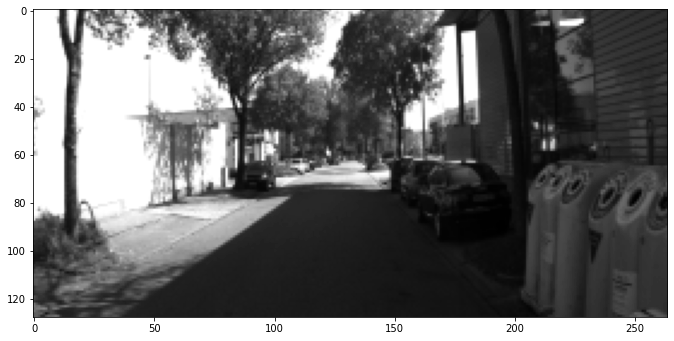

In [ ]:
plt.figure(figsize=[25,25])

plt.subplot(121)
curr_img = np.reshape(Xtrain[0], (128,264))
#curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')

In [ ]:
Xtrain= Xtrain.reshape(-1, 128,264, 1)
print(Xtrain.shape)

(453, 128, 264, 1)


In [ ]:
# from sklearn.model_selection import train_test_split
# train_X,valid_X,train_ground,valid_ground = train_test_split(Xtrain,
#                                                              Xtrain, 
#                                                              test_size=0.2, 
#                                                              random_state=13)
train_X = Xtrain[:400]
valid_X = Xtrain[400:]
train_ground = Xtrain[:400]
valid_ground = Xtrain[:400]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(400, 128, 264, 1)
(53, 128, 264, 1)
(400, 128, 264, 1)
(400, 128, 264, 1)


Origiinal image


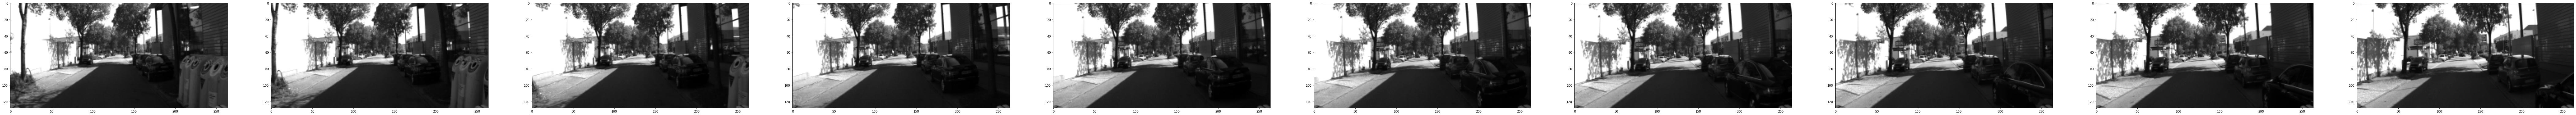

In [ ]:
plt.figure(figsize=(150, 150))
print("Origiinal image")
for i in range(10):
      plt.subplot(2, 10, i+1)
      plt.imshow(train_X[i, ..., 0], cmap='gray') 
plt.show() 

In [ ]:
batch_size = 2
epochs = 200
inChannel = 1
x, y = 128, 264
input_img = Input(shape = (x, y, inChannel))
decoder_input= Input(shape = ((16,33,256)))

In [ ]:
#Defining the encoder and the decoder
def encoder(input_img):
    conv1 = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #64 x 132 x 128
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #32 x 66 x 128
    conv3 = Conv2D(256, (3, 3), activation='tanh', padding='same')(pool2) #128 x 348 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #16 x 33 x 256
    return pool3

def decoder(decoder_input):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder_input) 
    up1 = UpSampling2D((2,2))(conv5) #32 x 66 x 128
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 128
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) # 128 x 264 x 128
    decoded = Conv2D(1, (7, 7), activation='relu', padding='same')(up3)
    return decoded


In [ ]:
encoder = Model(input_img, encoder(input_img))
decoder = Model(decoder_input, decoder(decoder_input))
encoder.summary()
decoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 264, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 264, 128)     6400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 132, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 132, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 66, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 66, 256)       295168    
___________________________________________

In [ ]:
#Build the Auto Encoder
encoded = encoder(input_img)
decoded = decoder(encoded)
print(encoded)
print(decoded)
auto_encoder = Model(input_img, decoded)
print(auto_encoder)
auto_encoder.compile(loss='mean_squared_error', optimizer = RMSprop())
auto_encoder.summary()

Tensor("model_1/max_pooling2d_3/MaxPool:0", shape=(?, 16, 33, 256), dtype=float32)
Tensor("model_2/conv2d_7/Relu:0", shape=(?, 128, 264, 1), dtype=float32)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 264, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 16, 33, 256)       449152    
_________________________________________________________________
model_2 (Model)              (None, 128, 264, 1)       596481    
Total params: 1,045,633
Trainable params: 1,045,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Load the weights to the autoencoder and train the autoencoder.
auto_encoder=load_model("/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_concat.h5")
autoencoder_train = auto_encoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))



In [ ]:
auto_encoder.save('/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_concat.h5')

In [ ]:
#Define the architecture of the Decoder
def decoder_final(code_combined):
    conv_dec_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(code_combined) 
    conv_dec_2 = UpSampling2D((2,2))(conv_dec_1) #32 x 66 x 1024
    conv_dec_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_dec_2) 
    conv_dec_4 = UpSampling2D((2,2))(conv_dec_3) # 64 x 132 x 256
    decoded = Conv2D(1, (7, 7), activation='tanh', padding='same')(conv_dec_4) 
    up3 = UpSampling2D((2,2))(decoded)# 128 x 264 x 1
    return up3

pred = auto_encoder.predict(valid_X)
print(pred.shape)

(53, 128, 264, 1)


Reconstruction of code layer


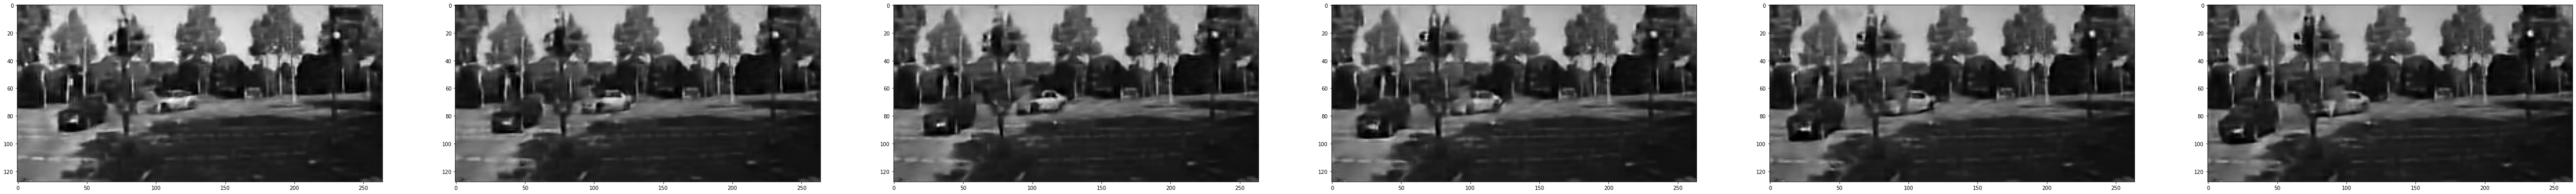

In [ ]:
plt.figure(figsize=(150, 150))
print("Reconstruction of code layer")
for i in range(6):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

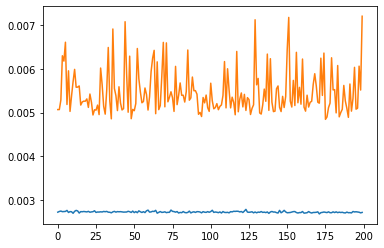

In [ ]:
train_loss = autoencoder_train.history['loss']
val_loss   = autoencoder_train.history['val_loss']
# train_acc  = autoencoder_train.history['acc']
# val_acc    = autoencoder_train.history['val_acc']
xc         = range(epochs)

plt.figure()
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)


In [ ]:
#Concatenating code layers of N frames (N=4)
def main_concat(tmp):
    s=tmp[0].reshape(-1,128,264,1)
    code_layer_frame1=encoder.predict(s)[0]
    temp_numpy=code_layer_frame1
    for j in range(1,len(tmp)):
      ss=tmp[j].reshape(-1,128,264,1)
      #generate code layers 
      code_layer_curr_frame=encoder.predict(ss)[0]
      concat_list=[]
      #concatenate the code layers obtained
      for a in range(0,len(code_layer_curr_frame)):
        concat_list.append(np.concatenate((temp_numpy[a],code_layer_curr_frame[a]),axis=1))
      temp_numpy=np.asarray(concat_list)
    return temp_numpy

def create_concat(train_X_new,start,stop):
  final_list=[]
  for i in range(start,stop):
    tmp=train_X_new[i:i+4]
    temp_numpy=main_concat(tmp)
    final_list.append(temp_numpy)
  return np.asarray(final_list)

#Final list contains the list of all the concatenated layers

In [ ]:
pred = encoder.predict(valid_X)
pred.shape

(53, 16, 33, 256)

In [ ]:
train_X_new = Xtrain[:404]
label_X_new = Xtrain[4:404]
test_X_new = Xtrain[399:414]
train_label_new = Xtrain[6:10]
test_label_new = Xtrain[403:408]
print(train_X.shape)
print(label_X_new.shape)
print(test_X_new.shape)
print(test_label_new.shape)

(400, 128, 264, 1)
(400, 128, 264, 1)
(15, 128, 264, 1)
(5, 128, 264, 1)


In [ ]:
# tmp=create_concat(train_X_new,0,400)
tmp=create_concat(train_X_new,0,50)
valid_X=create_concat(Xtrain,54,64)
# tmp=create_concat(train_X_new,0,400)
label_X_new = Xtrain[4:54]
valid_ground = Xtrain[58:68]
#print(tmp.shape)

In [ ]:
input_concatenated= Input(shape = (16,33,1024))
decoder_concat = Model(input_concatenated,decoder_final(input_concatenated))
opt=RMSprop(lr=0.00005)
decoder_concat.compile(loss="mean_squared_error",optimizer=opt)

In [ ]:
# decoder_concat=load_model('/gdrive/My Drive/Frame_prediction_kitti/decoder_concat.h5')
#Train the decoder separately
auto_encoder_final = decoder_concat.fit(tmp,label_X_new,batch_size=20,epochs=1000,verbose=1,validation_data=(valid_X, valid_ground))


Train on 50 samples, validate on 10 samples
Epoch 1/1000
50/50 [==============================] - 5s 104ms/step - loss: 0.1328 - val_loss: 0.0585
Epoch 2/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0593 - val_loss: 0.0474
Epoch 3/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0516 - val_loss: 0.0499
Epoch 4/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0527 - val_loss: 0.0438
Epoch 5/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0466 - val_loss: 0.0436
Epoch 6/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0467 - val_loss: 0.0429
Epoch 7/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0443 - val_loss: 0.0383
Epoch 8/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0431 - val_loss: 0.0417
Epoch 9/1000
50/50 [==============================] - 1s 15ms/step - loss: 0.0423 - val_loss: 0.0364
Epoch 10/1000
50/50 [=========================

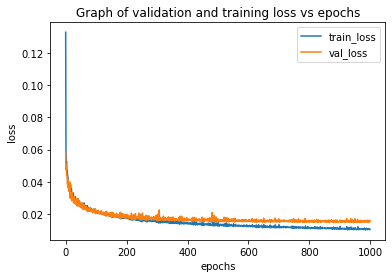

In [ ]:
train_loss = auto_encoder_final.history['loss']
val_loss   = auto_encoder_final.history['val_loss']
# train_acc  = autoencoder_train.history['acc']
# val_acc    = autoencoder_train.history['val_acc']
xc         = range(1000)

plt.figure()
plt.title("Graph of validation and training loss vs epochs")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.plot(xc, train_loss,label = "train_loss")
plt.plot(xc, val_loss, label="val_loss")
plt.legend()

In [ ]:
decoder_concat.save('/gdrive/My Drive/Frame_prediction_kitti/decoder_concat.h5')

yeyyy (4, 16, 33, 1024)
The input sequence  2 3 4 5


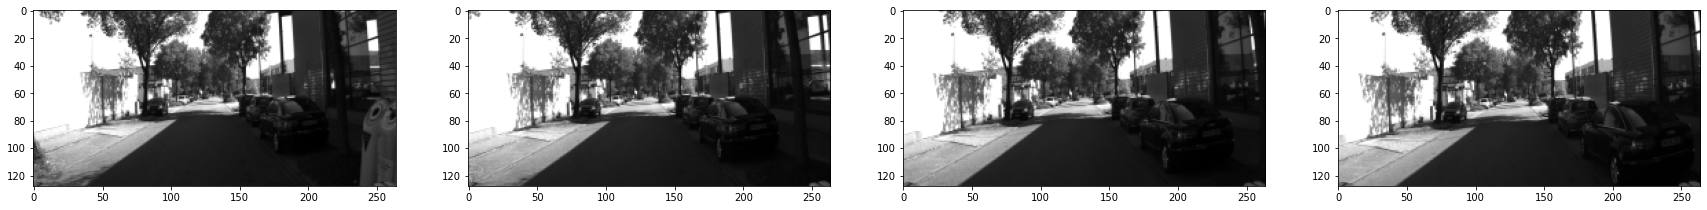

Predicted Output for the sequence is 


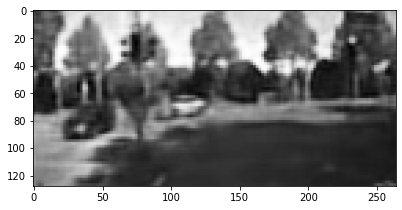

Original Output for the sequence is 


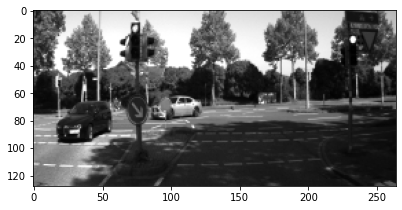

The input sequence  3 4 5 6


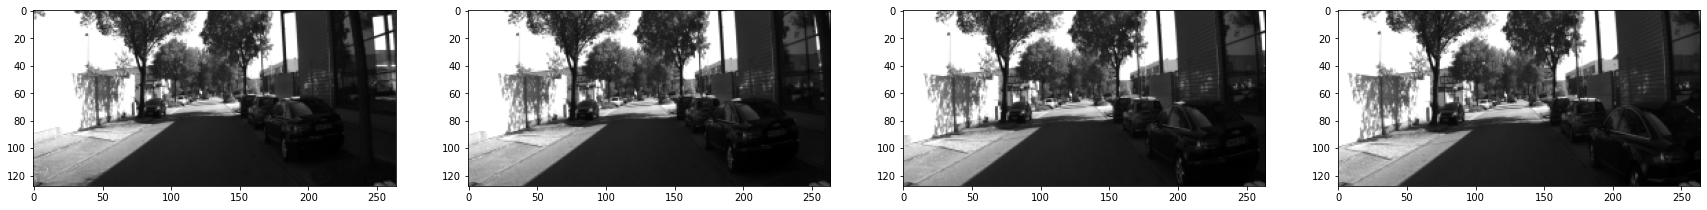

Predicted Output for the sequence is 


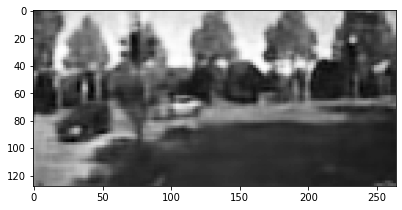

Original Output for the sequence is 


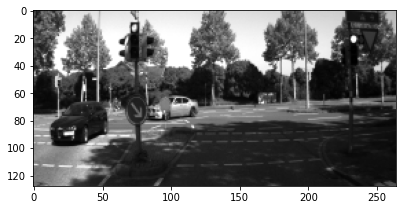

The input sequence  4 5 6 7


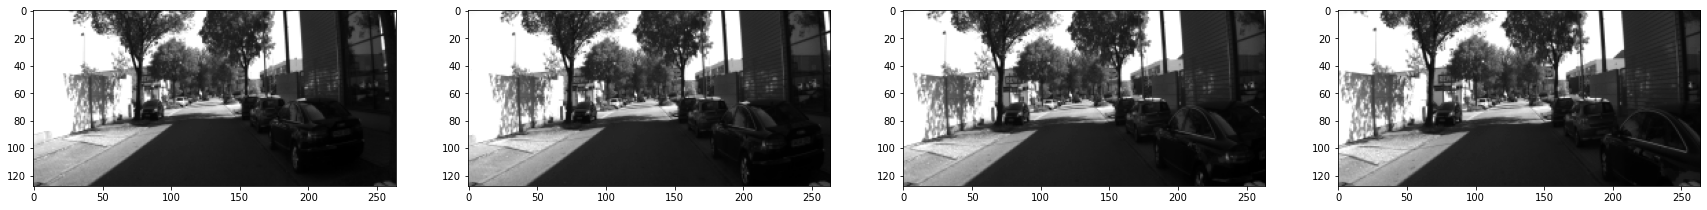

Predicted Output for the sequence is 


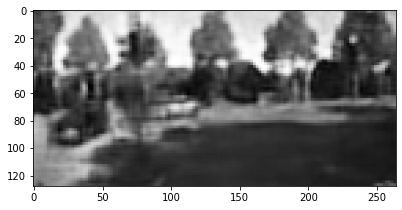

Original Output for the sequence is 


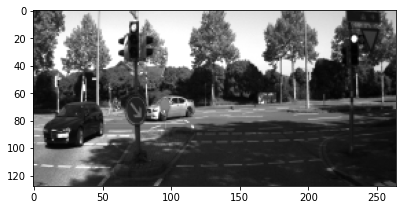

The input sequence  5 6 7 8


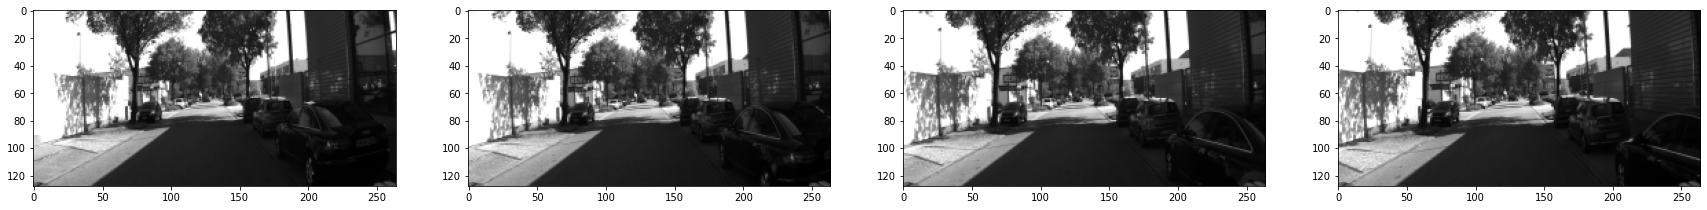

Predicted Output for the sequence is 


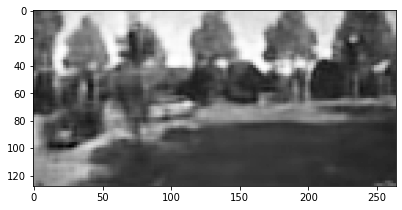

Original Output for the sequence is 


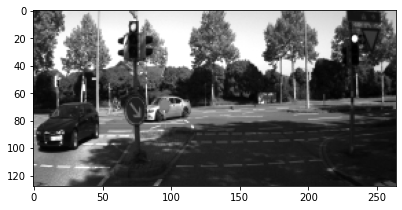

In [ ]:
#Predicting for training images
test=create_concat(train_X_new,2,6)
#test=test.reshape(-1,32,87,512)
print("yeyyy",test.shape)
final_pred = decoder_concat.predict(test_tmp)
for i in range(2,6):
  print("The input sequence ",i,i+1,i+2,i+3)
  plt.figure(figsize=(100, 100))
  for j in range(i,i+4):
    plt.subplot(2,13,j+1)
    plt.imshow(train_X_new[j,...,0],cmap='gray')
  plt.show()
  print("Predicted Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(final_pred[(i-2),...,0],cmap='gray')
  plt.show()
  print("Original Output for the sequence is ")
  plt.figure(figsize=(100, 100))
  plt.subplot(2,13,1)
  plt.imshow(test_label_new[(i-2),...,0],cmap='gray')
  plt.show()


yeyyy (5, 16, 33, 1024)
[[[0.6054067 ]
  [0.6054067 ]
  [0.67210925]
  ...
  [0.9901164 ]
  [0.969555  ]
  [0.969555  ]]

 [[0.6054067 ]
  [0.6054067 ]
  [0.67210925]
  ...
  [0.9901164 ]
  [0.969555  ]
  [0.969555  ]]

 [[0.62120485]
  [0.62120485]
  [0.6848604 ]
  ...
  [0.993292  ]
  [0.9665465 ]
  [0.9665465 ]]

 ...

 [[0.17944978]
  [0.17944978]
  [0.13785265]
  ...
  [0.22586344]
  [0.08406021]
  [0.08406021]]

 [[0.24524951]
  [0.24524951]
  [0.22850987]
  ...
  [0.41915902]
  [0.42371964]
  [0.42371964]]

 [[0.24524951]
  [0.24524951]
  [0.22850987]
  ...
  [0.41915902]
  [0.42371964]
  [0.42371964]]]
Reconstruction of Test Images


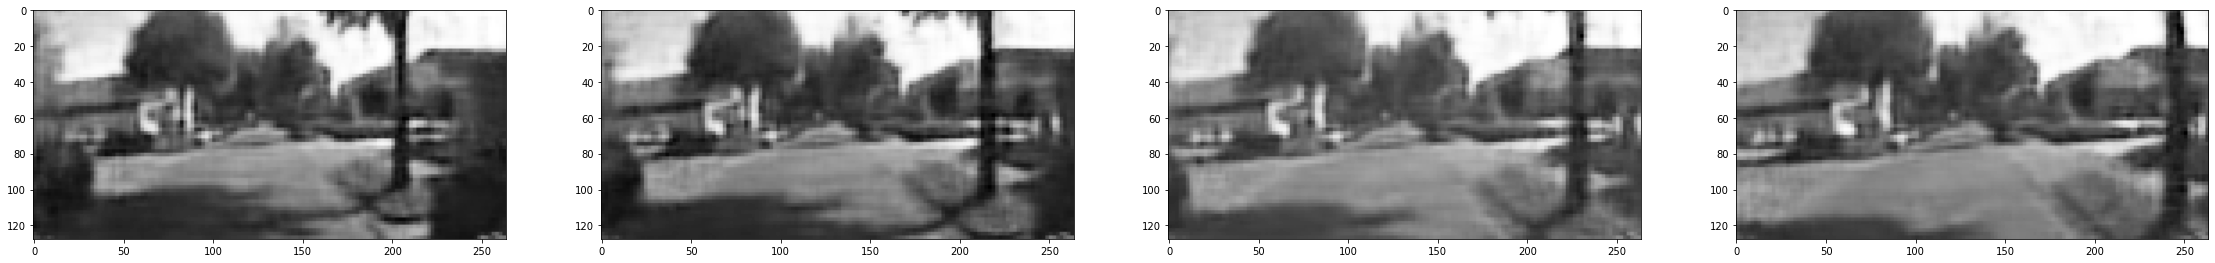

Reconstruction of Test Images


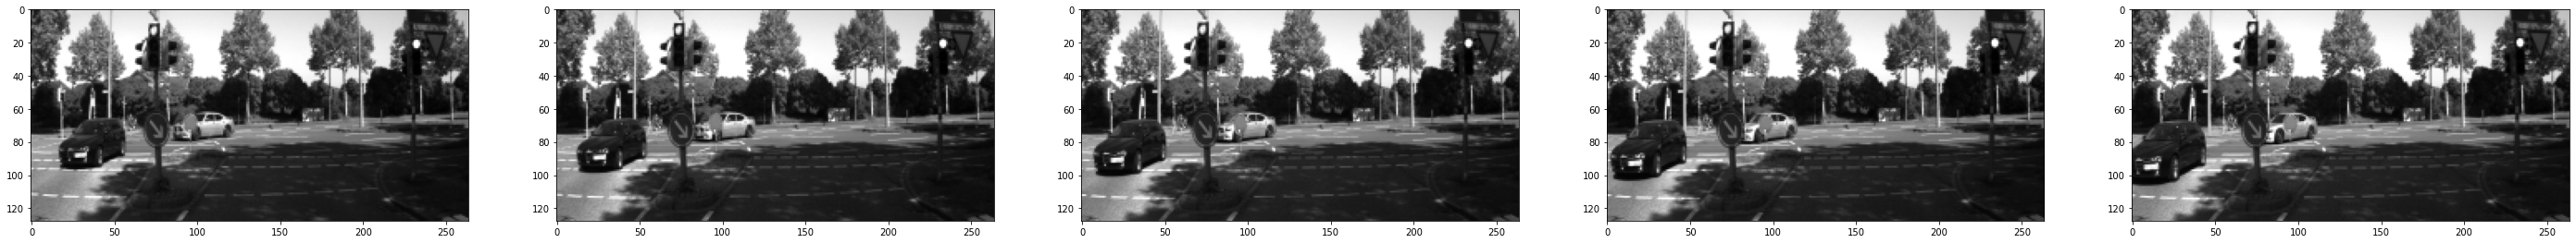

In [ ]:
#Predicting for testing images
test=create_concat(train_X_new,16,21)
#test=test.reshape(-1,32,87,512)
print("yeyyy",test.shape)
final_pred = decoder_concat.predict(test)
print(final_pred[1])
plt.figure(figsize=(100, 100))
print("Reconstruction of Test Images")
for i in range(4):
      plt.subplot(2, 10, i+1)
      plt.imshow(final_pred[i, ..., 0], cmap='gray')  
plt.show()
plt.figure(figsize=(100, 100))
print("Reconstruction of Test Images")
for i in range(5):
      plt.subplot(2, 10, i+1)
      plt.imshow(test_label_new[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
# Lets define the Discriminator 

from keras.layers import  Flatten,Dense
input_img_disc = Input(shape = (512, 1392, 1))
def discriminator(input_img_disc):
    conv1 = Conv2D(64, (4, 4),strides=(2,2), activation='relu', padding='same')(input_img_disc) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #256 x 696 x 64
    conv2 = Conv2D(128, (4, 4),strides=(2,2), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #128 x 348 x 128
    conv3 = Conv2D(256, (4, 4),strides=(2,2), activation='relu', padding='same')(pool2) #128 x 348 x 256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #64 x 174 x 256
   #conv4=Conv2D(512,(4,4),activation='relu',padding='same')(pool3)
    #pool4=MaxPooling2D(pool_size=(2,2))(conv4) # 32 x 87 x 128
    conv5=Conv2D(4,(1,1),activation='relu',padding='same')(pool3)
    flat=Flatten()(conv5)
    fake_real = Dense(100, activation='relu')(flat)
    fake_real2 = Dense(1, activation='sigmoid')(fake_real)
    return fake_real2

In [ ]:
discriminator = Model(input_img_disc, discriminator(input_img_disc))
discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 512, 1392, 1)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 696, 64)      1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 348, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 174, 128)      131200    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 87, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 44, 256)       524544    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 22, 256)        0   

In [ ]:
train_X = Xtrain[6:10]
valid_X = Xtrain[22:]
train_ground = Xtrain[:22]
valid_ground = Xtrain[22:]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(4, 128, 264, 1)
(6, 128, 264, 1)
(22, 128, 264, 1)
(6, 128, 264, 1)


In [ ]:
print(final_pred.shape)
print(train_X.shape)
train_disc=[]
#for i in final_pred:
#  train_disc.append(i)
for i in train_X:
  train_disc.append(i)

train_disc=np.asarray(train_disc)
y_real = np.ones((4, 1))
label_disc=np.asarray(label_disc)
print(train_disc.shape)
print(y_real.shape)

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(0.002, 0.5)
discriminator.compile(loss='binary_crossentropy', optimizer = optimizer)
discriminator_loss= discriminator.fit(train_X,y_real,batch_size=2,epochs=10,verbose=1)

In [ ]:
discriminator.predict(train_X)

In [ ]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model(gen_out)
	# src image as input, generated image and classification output
	model = Model(in_src, dis_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB, title,X_train):
	# compute the mean squared error and structural similarity
	# index for the images

	# setup the figure
	
	for i in range(4):
		m = mse(imageA[i], imageB[i])
		s = measure.compare_ssim(imageA[i], imageB[i],multichannel=True)
		print("Input sequence is")
		plt.figure(figsize=(100, 100))
		for j in range(i,i+4):
			plt.subplot(2,13,j+1)
			plt.imshow(X_train[j,...,0],cmap='gray')
		plt.show()
		# plt.suptitle("MSE: %.4f, SSIM: %.4f" % (m, s))
	# show first image
		print("Predicted Frame is -")
		plt.figure(figsize=(100, 100))
		plt.subplot(2,13,j+1)
		plt.title("MSE: %.4f, SSIM: %.4f" % (m, s))
		plt.imshow(imageA[i,...,0],cmap='gray')
		plt.show()
	# show the second image
		print("Original Frame is -")
		plt.figure(figsize=(100, 100))
		plt.subplot(2,13,j+1)
		plt.imshow(imageB[i,...,0],cmap='gray')	

	# show the images
		plt.show()

In [ ]:
X_real=Xtrain[403:408]
pred=pred[:5]
X_train=Xtrain[399:409]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Input sequence is


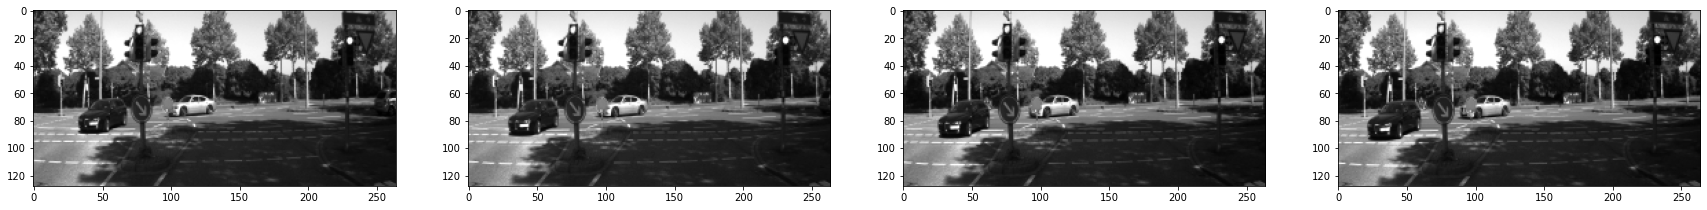

Predicted Frame is -


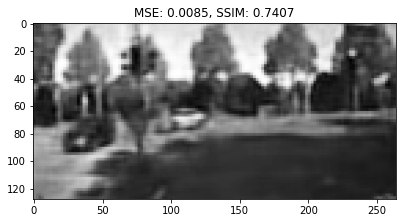

Original Frame is -


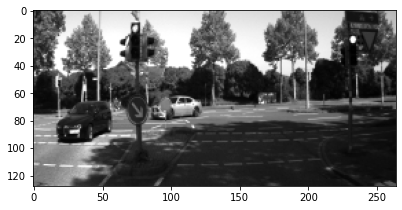

Input sequence is


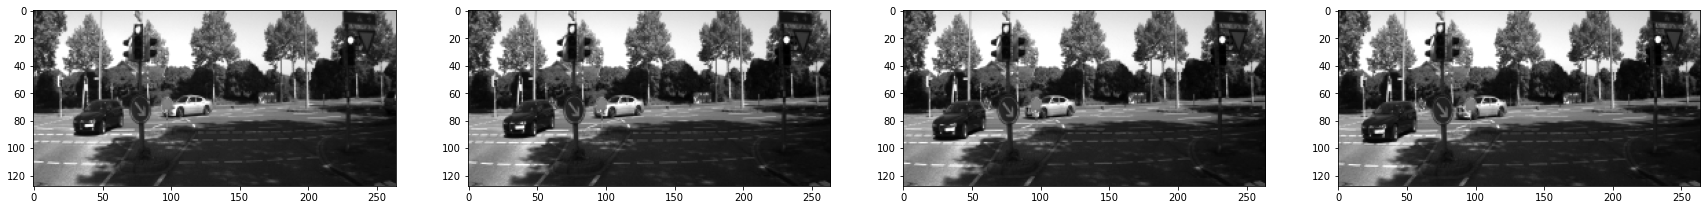

Predicted Frame is -


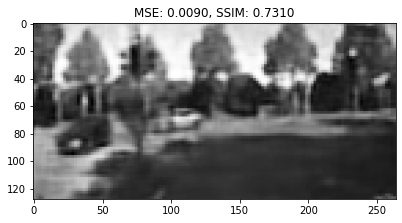

Original Frame is -


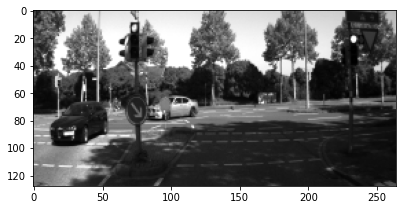

Input sequence is


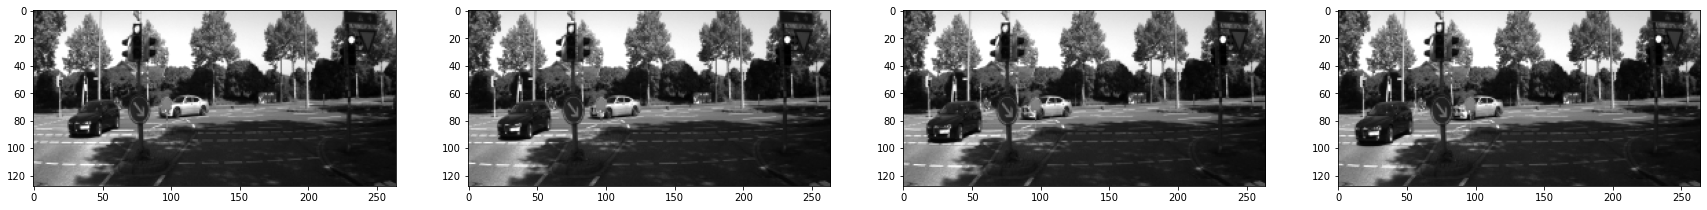

Predicted Frame is -


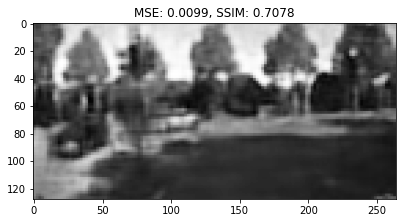

Original Frame is -


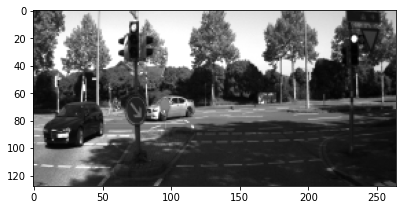

Input sequence is


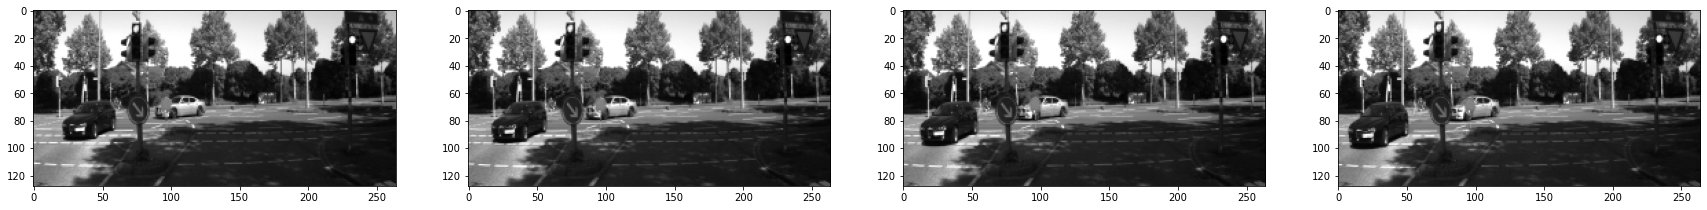

Predicted Frame is -


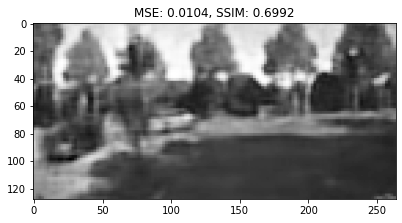

Original Frame is -


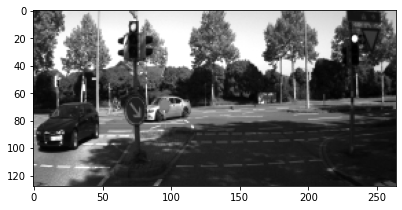

In [ ]:
compare_images(final_pred,X_real,"hello",X_train)